# Food App

In this project, we will be working in a company that sells food product and we will  investigate user behavior for the company's app.  
First, we will study the sales funnel, find out how users reach the purchase stage. As well as how many users actually make it to this stage, and how many get stuck at previous stages.  
Then we will have a look at the results of an A/A/B test that were concluded in order to make a decision regarding to change the fonts for the entire app.   

The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. We will try to find out which set of fonts produces better results.  

Creating two A groups has certain advantages. We can make it a principle that we will only be confident in the accuracy of our testing when the two control groups are similar. If there are significant differences between the A groups, this can help us uncover factors that may be distorting the results. Comparing control groups also tells us how much time and data we'll need when running further tests.

We'll be using the same dataset for general analytics and for A/A/B analysis.

## Table of Content
1. [Importing Libraries and Reading Files](#import)  


2. [Data Pre-processing](#preprocessing)  
    2.1. [Duplicates](#dup)  
    

3. [Study And Check The Data](#3)  
    3.1. [Number of Events](#3.1)  
    3.2. [Number of Users](#3.2)  
    3.3. [Average Number of Events per User](#3.3)  
    3.4. [Relevant Time Period](#3.4)  
    3.5. [Relevant data Share](#3.5)  
    3.6. [Experimental groups](#3.6)  
    

4. [Funnel Research](#4)  
    4.1. [Frequency of Occurence of Events](#4.1)  
    4.2. [Share of Occurence per Event](#4.2)  
    4.3. [Sequence of Actions](#4.3)  
    4.4. [The share of users converting - The Funnel](#4.4)  
  

5. [Experiment Results](#5)  
    5.1. [Number of Users in Groups](#5.1)  
    5.2. [A\A Test](#5.2)  
    5.3. [A\B Test](#5.3)  
    5.4. [A\A\B Test](#5.4)  
    5.5. [Conclusions](#conclusions)  
    5.6. [The Benforroni Correction](#5.5)  

    
    





### 1. Importing libraries and reading data files <a id="import"></a> 

In [1]:
# Importing libraries
import pandas as pd
import datetime as dt
import sys
!{sys.executable} -m pip install plotly
!pip install -U kaleido
import kaleido
import plotly.express as px
import plotly.graph_objects as go
import math
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import Markdown, display

In [2]:
# reading datasets and storing them into variables
try:
    logs_df = pd.read_csv('datasets/logs_exp_us.csv', sep='\t')
except:
    logs_df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

In [3]:
# Lets' have a look at the data:
logs_df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# checking the info:
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### 2. Data Pre-Processing <a id="preprocessing"></a> 

In [5]:
# Renaming columns:
logs_df.columns = ['event_name','device_id','event_timestamp','group_id']
logs_df.head()

,event_name,device_id,event_timestamp,group_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
# Adding date columns:
logs_df['event_datetime'] = pd.to_datetime(logs_df['event_timestamp'], unit='s')
logs_df.head()

,event_name,device_id,event_timestamp,group_id,event_datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


#### Duplicates <a id='dup'></a>

In [7]:
# Checking how many duplicates we have:
dup = logs_df.duplicated().sum()
print('We have {} duplicates. And they form {:.3%} of our dataset.'.format(dup, dup/len(logs_df)))

We have 413 duplicates. And they form 0.169% of our dataset.


In [8]:
# Checking the duplicates out:
logs_df[logs_df.duplicated()].head()

,event_name,device_id,event_timestamp,group_id,event_datetime
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39
3573,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37
4076,MainScreenAppear,3761373764179762633,1564631266,247,2019-08-01 03:47:46
4803,MainScreenAppear,2835328739789306622,1564634641,248,2019-08-01 04:44:01


In [9]:
# Let's see the first item for example:
logs_df[logs_df.event_timestamp==1564474784]

,event_name,device_id,event_timestamp,group_id,event_datetime
452,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44


**We can see that the same event happened in the exact same second**  
We will check how the duplicated events is scattered among the dataset

In [10]:
# Check how many duplicates we have per column:
for i in logs_df[logs_df.duplicated()].columns:
    print(i,':', logs_df[logs_df.duplicated()][i].nunique())

event_name : 5
device_id : 237
event_timestamp : 352
group_id : 3
event_datetime : 352


In [11]:
# Checking the unique dates in the duplicated data
logs_df[logs_df.duplicated()]['event_datetime'].dt.date.unique()

array([datetime.date(2019, 7, 30), datetime.date(2019, 7, 31),
       datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 3), datetime.date(2019, 8, 4),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7)], dtype=object)

Duplicates are scattered between the end of July until mid August.  
We will now check if we have duplicated in our experiment groups

In [12]:
# Checking the experiments group:
logs_df.groupby(['device_id'])['group_id'].nunique().reset_index().query('group_id>1')

,device_id,group_id


We dont have the same user id in both groups.  
Since we can't find any "rules" for the duplicates and they form only a tiny fraction from the sample we decide to drop them.

In [13]:
# Dropping duplicates:
df = logs_df.drop_duplicates(subset=['device_id','event_timestamp'])
df.head()

,event_name,device_id,event_timestamp,group_id,event_datetime
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42
5,CartScreenAppear,6217807653094995999,1564055323,248,2019-07-25 11:48:43


### 3. Studying and Checking the Data <a id="3"></a> 

- **The number of events in the logs** <a id='3.1'></a> 

In [14]:
# Calculate the number of appearance of each of the 5 events in the logs
df.event_name.value_counts()

MainScreenAppear           115911
OffersScreenAppear          46560
CartScreenAppear            32140
PaymentScreenSuccessful     24930
Tutorial                     1016
Name: event_name, dtype: int64

- **The number of users in the logs** <a id='3.2'></a> 

In [15]:
# Calculate the unique number of devices in the logs:
events_number = df['device_id'].nunique()
print('We have {} events in the logs'.format(events_number))

We have 7551 events in the logs


- **The average number of events per user** <a id='3.3'></a>

In [16]:
event_per_user = df.groupby(['device_id'])['event_name'].count().reset_index()
event_per_user.columns=['device_id','number_of_events']
print('We have on average {:.2f} events per user'.format(event_per_user.number_of_events.mean()))
event_per_user.sample(5)

We have on average 29.21 events per user


,device_id,number_of_events
4277,5295139592252561101,13
5871,7247480119368198552,8
4710,5828159031774533786,13
1098,1417516282838937775,15
6806,8351860793733343758,11


- **Finding the relevant time period** <a id='3.4'></a>

In [17]:
# Calculating the minimum and maximum dates:
start_date = df.event_datetime.min().date()
end_date = df.event_datetime.max().date()

print('The tests start on {} and ends on {}'.format(start_date,end_date))

The tests start on 2019-07-25 and ends on 2019-08-07


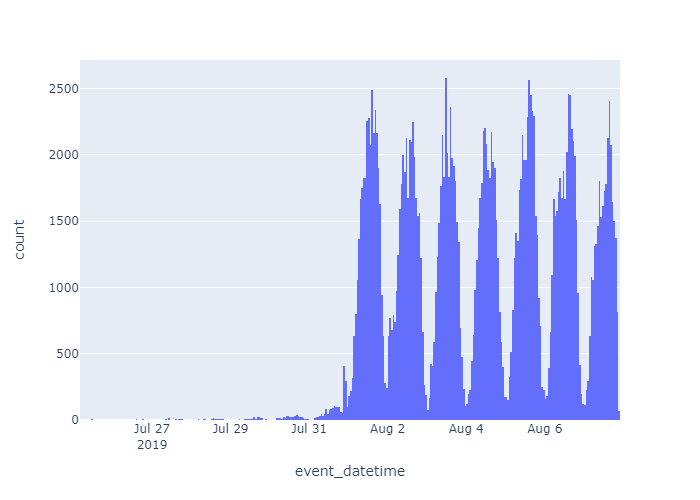

In [48]:
# Plotting histogram
fig = px.histogram(df, x="event_datetime")
fig.show("png")

We can see that the data start to be complete somewhere around August 1st, we will drop the data on earlier priods and see what would be the result of that.

In [19]:
# Creating a data set with the data starting from the first of August
rel_data = df[df.event_datetime >= '2019-08-01']
rel_data.head()

,event_name,device_id,event_timestamp,group_id,event_datetime
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59


- **Relevant data share of the original data** <a id='3.5'></a>

In [20]:
# Checking the percentage of data loss:
print('Relevant data is {:.2%} of the original data which are {} events'.format(len(rel_data)/len(df), len(df)-len(rel_data)))

Relevant data is 98.79% of the original data which are 2659 events


- **Checking experimental groups in relevant data** <a id='3.6'></a>

In [21]:
# Checking we have users if all gorups
rel_data.groupby('group_id').agg({'device_id':'nunique'}).reset_index()

,group_id,device_id
0,246,2484
1,247,2513
2,248,2537


We have similar number of users in experimental group. We are good to go!

### 4. Funnel Research <a id="4"></a> 

- **The frequency of the occurrence of events** <a id='4.1'></a>

In [22]:
# Grouping by event name and sorting by frequency:
rel_data.groupby('event_name').agg({'device_id':'count'}).reset_index().sort_values(by='device_id', ascending=False)

,event_name,device_id
1,MainScreenAppear,114155
2,OffersScreenAppear,46086
0,CartScreenAppear,31854
3,PaymentScreenSuccessful,24800
4,Tutorial,1003


- **The share of the occurrence of each event** <a id='4.2'></a>

In [23]:
# Grouping by event name and calculating the number of users and their share of all unique users
event_nunique = rel_data.groupby('event_name').agg({'device_id':'nunique'}).reset_index().sort_values(by='device_id', ascending=False)
event_nunique.columns = ['event_name','users']
event_nunique['%'] = round((event_nunique.users/event_nunique.users.sum())*100,2)
event_nunique

,event_name,users,%
1,MainScreenAppear,7418,37.75
2,OffersScreenAppear,4586,23.34
0,CartScreenAppear,3488,17.75
3,PaymentScreenSuccessful,3316,16.88
4,Tutorial,840,4.28


- **The sequence of actions** <a id='4.3'></a>

According to the number of events and common sence, we suspect that the sequence of event, excluding the tutorial, is as following:  
**MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful**  

But we can actually check it according to the timestamp for each user. So let's do it

In [24]:
# Slicing the data to exclude the tutorial event:
data = rel_data[rel_data.event_name!='Tutorial']

# Sorting the data by timestamp and user
data = data.sort_values(by=['device_id','event_timestamp'])
data.head()

,event_name,device_id,event_timestamp,group_id,event_datetime
197263,MainScreenAppear,6888746892508752,1565100394,246,2019-08-06 14:06:34
209196,MainScreenAppear,6909561520679493,1565117574,247,2019-08-06 18:52:54
209199,PaymentScreenSuccessful,6909561520679493,1565117578,247,2019-08-06 18:52:58
209210,OffersScreenAppear,6909561520679493,1565117584,247,2019-08-06 18:53:04
127670,MainScreenAppear,6922444491712477,1564928373,246,2019-08-04 14:19:33


We will create a list with the sequence for each unique user

In [25]:
# Creating a function to apply for each row
def sequence(user):
    sorted_user=data[data['device_id']==user].sort_values(by=['device_id','event_timestamp'])
    return sorted_user['event_name'].drop_duplicates().to_list()

# Testing the function for user: 6909561520679493
sequence(6909561520679493)

['MainScreenAppear', 'PaymentScreenSuccessful', 'OffersScreenAppear']

In [26]:
# Applying for all users in data frame:
sequence_list=[]
for i in data.device_id.unique():
    sequence_list.append([i,sequence(i)])

In [27]:
# Creating a dataframe from the list we created
sequence_df = pd.DataFrame(sequence_list, columns=['device_id','path'])
sequence_df.head()

,device_id,path
0,6888746892508752,[MainScreenAppear]
1,6909561520679493,"[MainScreenAppear, PaymentScreenSuccessful, Of..."
2,6922444491712477,"[MainScreenAppear, PaymentScreenSuccessful, Of..."
3,7435777799948366,[MainScreenAppear]
4,7702139951469979,"[MainScreenAppear, OffersScreenAppear, CartScr..."


We have a dataframe with all unique users and their sequence of events, let's check how many follows each sequence

In [28]:
sequence_df.path = sequence_df.path.astype('string')
sequence_df.path.value_counts()

['MainScreenAppear']                                                                         2883
['MainScreenAppear', 'OffersScreenAppear']                                                    883
['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']     805
['MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear']     767
['MainScreenAppear', 'CartScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful']     445
['MainScreenAppear', 'PaymentScreenSuccessful', 'OffersScreenAppear', 'CartScreenAppear']     325
['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear']                                227
['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear']     226
['MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful']                         136
['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'OffersScreenAppear']     123
['MainScreenAppear',

Out estimation was correct, we can see that most users' path was [MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful] 

- **The share of user converting to the next stage** <a id='4.4'></a>

In [29]:
# We already have a table with the number of users in each events
event_nunique

,event_name,users,%
1,MainScreenAppear,7418,37.75
2,OffersScreenAppear,4586,23.34
0,CartScreenAppear,3488,17.75
3,PaymentScreenSuccessful,3316,16.88
4,Tutorial,840,4.28


In [30]:
# Adding a column for percental change
event_nunique['pct_change'] = round(abs(event_nunique.users.pct_change()),2)*100
event_nunique

,event_name,users,%,pct_change
1,MainScreenAppear,7418,37.75,NaN
2,OffersScreenAppear,4586,23.34,38.0
0,CartScreenAppear,3488,17.75,24.0
3,PaymentScreenSuccessful,3316,16.88,5.0
4,Tutorial,840,4.28,75.0


We lose 38% of users from the main screen to the offer screen. we recommend to check that!

In [31]:
# Creating funnel groups:
funnel_grp=[]
for i in data.group_id.unique():
    grp=data[data.group_id==i].groupby(['event_name','group_id'])['device_id'].nunique().reset_index().sort_values(by='device_id',ascending=False)
    display(grp)
    funnel_grp.append(grp)

,event_name,group_id,device_id
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1541
0,CartScreenAppear,246,1174
3,PaymentScreenSuccessful,246,1122


,event_name,group_id,device_id
1,MainScreenAppear,247,2475
2,OffersScreenAppear,247,1519
0,CartScreenAppear,247,1159
3,PaymentScreenSuccessful,247,1083


,event_name,group_id,device_id
1,MainScreenAppear,248,2493
2,OffersScreenAppear,248,1526
0,CartScreenAppear,248,1155
3,PaymentScreenSuccessful,248,1111


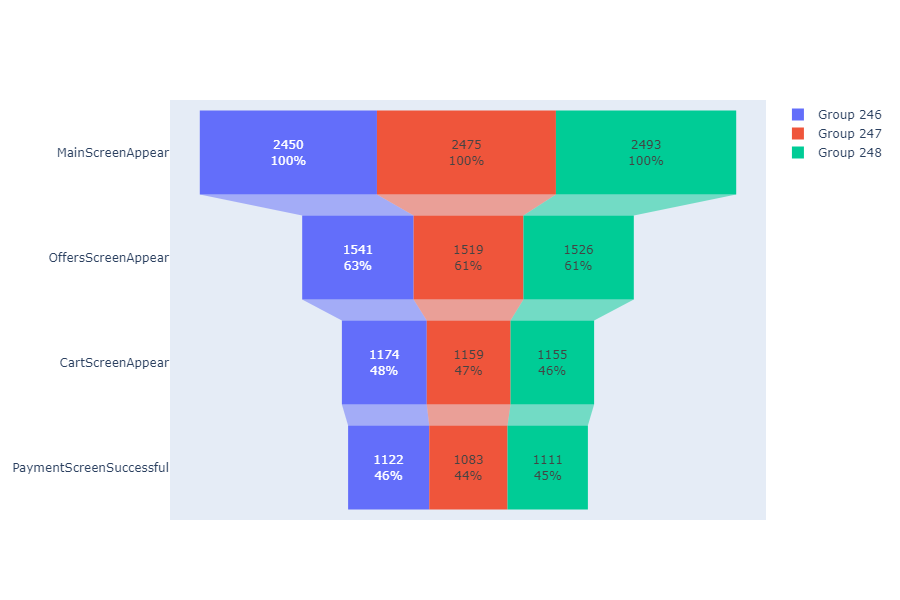

In [47]:
fig = go.Figure()
for funnel in funnel_grp:
    fig.add_trace(go.Funnel(
        name='Group '+str(funnel.group_id[0]),
        y = funnel.event_name,
        x = funnel.device_id,
        textposition = "inside",
        textinfo = "value+percent initial"))
    
fig.update_layout(height=600, width=900)
fig.show("png")

As shown in the funnel graph above,  
excluding the tutorial event, as we saw earlier we lose most of the users between the main screen and the offer screen.  
We lost almost 37 - 39% across the group.  
Only 45% - 46% in each group make the whole path from the main screen to the payment.


### 5. Experiment Results <a id="5"></a> 

In this clause we will be performing statistical tests on the difference groups.  
We will test both A/A groups 246 and 247 for significant difference as well as the control groups.  

Our hypotheses will be as follows:  

The **null hypothesis** $H_0$ would be: There is no difference between the groups.


The null hypothesis was formulated this way based on the fact that the hypothesis testing checks wether or not a sample is equal (or close enough) to a value, or another sample. This is by definition.

The **alternative hypothesis** $H_1$ would be: There is difference between the groups.

We will conduct the tests with signifance level $a$ = 5%


- **The number of users in each group** <a id='5.1'></a>

In [33]:
# Group by 'group_id' and calculate unique users in each group:
rel_data.groupby('group_id')['device_id'].nunique().reset_index()


,group_id,device_id
0,246,2484
1,247,2513
2,248,2537


- **Significant difference test between the A/A groups** <a id='5.2'></a>

In [34]:
# First we will re-check if we have users that are in both groups 246 and 247
rel_data.groupby(['device_id'])['group_id'].nunique().reset_index().query('group_id>1')

,device_id,group_id


We have established once again that we dont have users that belong to both groups

In [35]:
# Creating a pivot table to check the propotions of the groups:
pvt = rel_data.pivot_table(index='event_name', values='device_id', columns='group_id', aggfunc='nunique').reset_index()
pvt

group_id,event_name,246,247,248
0,CartScreenAppear,1174,1159,1155
1,MainScreenAppear,2450,2475,2493
2,OffersScreenAppear,1541,1519,1526
3,PaymentScreenSuccessful,1122,1083,1111
4,Tutorial,278,283,279


In [36]:
rel_data

,event_name,device_id,event_timestamp,group_id,event_datetime
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58


We can now make Z-tests for proportions in our groups. We will create a custom functions for this whole operation

In [37]:
def check_hypothesis(df,group1,group2,group3,event,alpha=0.05,combined=False):
    """Perform a statistical Z-test (Proportions Tets) between 2 or 3 groups

    Parameters:
    df (DataFrame): Data Frame containing the relevant data groups
    group1 (str): First group to be tested
    group2 (str): Second group to be tested
    group3 (str): Third group to be tested
    event (str): Name of the event to be tested
    alpha (float): Signifance Level
    combined(bool): True for combining group1 and group2 and test against group3

    Returns:
    float:P-Value
    str: Rejection\Acceptance of Null Hypothesis

   """
    success1=pvt[pvt.event_name==event][group1].iloc[0]
    success2=pvt[pvt.event_name==event][group2].iloc[0]
    
    
    trials1=df[df.group_id==group1]['device_id'].nunique()
    trials2=df[df.group_id==group2]['device_id'].nunique()

    
    if (combined):
        success3=pvt[pvt.event_name==event][group3].iloc[0]
        trials3=df[df.group_id==group3]['device_id'].nunique()
    
    
    # success proportion in the first group:
    if (combined):
        p1 = (success1+success2) / (trials1+trials2)
    else:
        p1 = success1/trials1


    # success proportion in the second group:
    if (combined):
        p2 = success3/trials3
    else:
        p2 = success2/trials2

    # success proportion in the combined dataset:
    if (combined):
        p_combined =(success1 + success2 + success3) / (trials1 + trials2 + trials3)
    else:
        p_combined = (success1 + success2) / (trials1 + trials2)

    # the difference between the datasets' proportions
    difference = p1 - p2
    # calculating the statistic in standard deviations of the standard normal distribution
    if (combined):
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2+ 1/trials3))
    else:
        z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # setting up the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)
    # calculating the statistic in standard deviations of the standard normal distribution


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    
    if (combined):
            if (p_value < alpha ):
                print("Rejecting the null hypothesis for", event,"in the combined A/A groups and the control group", group3)
            else:
                print("Failed to reject the null hypothesis for",event,"in the combined A/A groups and the control group", group3)
    else:
        if (p_value < alpha ):
            print("Rejecting the null hypothesis for", event,"in groups", group1,group2)
        else:
            print("Failed to reject the null hypothesis for",event,"in groups", group1,group2 )    

In [38]:
# Checking Docstrings
help(check_hypothesis)

Help on function check_hypothesis in module __main__:

check_hypothesis(df, group1, group2, group3, event, alpha=0.05, combined=False)
    Perform a statistical Z-test (Proportions Tets) between 2 or 3 groups
    
    Parameters:
    df (DataFrame): Data Frame containing the relevant data groups
    group1 (str): First group to be tested
    group2 (str): Second group to be tested
    group3 (str): Third group to be tested
    event (str): Name of the event to be tested
    alpha (float): Signifance Level
    combined(bool): True for combining group1 and group2 and test against group3
    
    Returns:
    float:P-Value
    str: Rejection\Acceptance of Null Hypothesis



In [39]:
# Checking the function :)
check_hypothesis(rel_data,246,247,248,'CartScreenAppear')

p-value:  0.41836972926292404
Failed to reject the null hypothesis for CartScreenAppear in groups 246 247


**Ok, Function works. Now we will loop it over all of the events.**

In [40]:
# Running the functions over each of the events for the A/A testing groups:
for event in pvt.event_name.unique():
    if event != 'Tutorial':
        check_hypothesis(rel_data,246,247,0,event)
        print()
        

p-value:  0.41836972926292404
Failed to reject the null hypothesis for CartScreenAppear in groups 246 247

p-value:  0.6706601610518881
Failed to reject the null hypothesis for MainScreenAppear in groups 246 247

p-value:  0.24832332591851847
Failed to reject the null hypothesis for OffersScreenAppear in groups 246 247

p-value:  0.14002096506482054
Failed to reject the null hypothesis for PaymentScreenSuccessful in groups 246 247



**Findings:** We failed to reject the null hypothesis for each of the event in both A/A testing groups. This means that the A/A test is successfull since there is no significant different between the A/A groups 246 and 247.

- **Significant difference between the A/B groups** <a id='5.3'></a>

In [41]:
# Running the functions over each of the events for the A/B testing groups 246 and 248:
for event in pvt.event_name.unique():
    if event != 'Tutorial':
        check_hypothesis(rel_data,246,248,0,event)
        print()

p-value:  0.2174036500463501
Failed to reject the null hypothesis for CartScreenAppear in groups 246 248

p-value:  0.2949721933554552
Failed to reject the null hypothesis for MainScreenAppear in groups 246 248

p-value:  0.17027180234958306
Failed to reject the null hypothesis for OffersScreenAppear in groups 246 248

p-value:  0.3261816838044478
Failed to reject the null hypothesis for PaymentScreenSuccessful in groups 246 248



**Findings:** We failed to reject the null hypothesis for each of the event in both A/B testing groups. This means that there is no significant different between the A/B groups 246 and 248.

In [42]:
# Running the functions over each of the events for the A/B testing groups 247 and 248:
for event in pvt.event_name.unique():
    if event != 'Tutorial':
        check_hypothesis(rel_data,247,248,0,event)
        print()

p-value:  0.6718818120786816
Failed to reject the null hypothesis for CartScreenAppear in groups 247 248

p-value:  0.5321989221028889
Failed to reject the null hypothesis for MainScreenAppear in groups 247 248

p-value:  0.8298611914457079
Failed to reject the null hypothesis for OffersScreenAppear in groups 247 248

p-value:  0.617860113650988
Failed to reject the null hypothesis for PaymentScreenSuccessful in groups 247 248



**Findings:** We failed to reject the null hypothesis for each of the event in both A/B testing groups. This means that there is no significant different between the A/B groups 247 and 248.

- **Significant difference between the A/A/B groups** <a id='5.4'></a>

In [43]:
# Running the functions over each of the events for the A/A/B testing groups 246 combined with 247 and 248:
for event in pvt.event_name.unique():
    if event != 'Tutorial':
        check_hypothesis(rel_data,246,247,248,event,combined=True)
        print()

p-value:  0.5002407026768461
Failed to reject the null hypothesis for CartScreenAppear in the combined A/A groups and the control group 248

p-value:  0.49045461508053734
Failed to reject the null hypothesis for MainScreenAppear in the combined A/A groups and the control group 248

p-value:  0.5193374525960561
Failed to reject the null hypothesis for OffersScreenAppear in the combined A/A groups and the control group 248

p-value:  0.8453837393508368
Failed to reject the null hypothesis for PaymentScreenSuccessful in the combined A/A groups and the control group 248



**Findings:** We failed to reject the null hypothesis for each of the event in the A/A/B testing groups. This means that there is no significant different between the combined A/A groups 246, 247 and the control group 248.

#### Conclusions <a id='conclusions'></a>
We have tested if there is a difference between the following groups of signifance of $a$ = 5%:
 - A\A groups 246 and 247
 - A\B groups 246 and 248
 - A\B groups 247 and 248
 - A\A\B combined A\A group 246,247 and control group 248 

In all these tests, in each of the events, we failed the reject the null hypothesis which said that the groups are different.  

The A/A test groups made us conclude that the procedure of data collection was ok.  

Both of A/B tests made us conclude that the change in the font in the web pages (events) did not generate any signifcant difference in user behavior considering signifance level of $a$ = 5%

- **The Bonferroni correction** <a id='5.5'></a>

We have concluded multiple tests on the same population, this means that we need to adjust the signifance level $a$ in order to prevent false discoveries.  
We will adjust the signifance level $a$ according the Bonferroni formula as follows...

In [44]:
# Calculate the amount of tests:
num_groups = 4
num_events = 4
m = num_groups * num_events
print('We have concluded',m,'tests')

We have concluded 16 tests


In [45]:
# Calculating new signifant level:
alpha = 0.05
alpha = alpha / m
print('The new signficance level alpha is {:.3f}'.format(alpha))

The new signficance level alpha is 0.003


**We have adjusted the signifance level according the Bonferroni correction and now it is 0.003**  

We will repeat the tests using the new signifance level and draw conclusions.


In [46]:
# Re-testing using the same function and new alpha
for event in pvt.event_name.unique():
    if event != 'Tutorial':
        check_hypothesis(rel_data,246,247,0,event,alpha=0.003)
        print()
        check_hypothesis(rel_data,246,248,0,event,alpha=0.003)
        print()
        check_hypothesis(rel_data,247,248,0,event,alpha=0.003)
        print()
        check_hypothesis(rel_data,246,247,248,event,alpha=0.003,combined=True)
        print()


p-value:  0.41836972926292404
Failed to reject the null hypothesis for CartScreenAppear in groups 246 247

p-value:  0.2174036500463501
Failed to reject the null hypothesis for CartScreenAppear in groups 246 248

p-value:  0.6718818120786816
Failed to reject the null hypothesis for CartScreenAppear in groups 247 248

p-value:  0.5002407026768461
Failed to reject the null hypothesis for CartScreenAppear in the combined A/A groups and the control group 248

p-value:  0.6706601610518881
Failed to reject the null hypothesis for MainScreenAppear in groups 246 247

p-value:  0.2949721933554552
Failed to reject the null hypothesis for MainScreenAppear in groups 246 248

p-value:  0.5321989221028889
Failed to reject the null hypothesis for MainScreenAppear in groups 247 248

p-value:  0.49045461508053734
Failed to reject the null hypothesis for MainScreenAppear in the combined A/A groups and the control group 248

p-value:  0.24832332591851847
Failed to reject the null hypothesis for OffersScr

**Conclusions**  
Even after adjusting the signifance level according to the Benforroni correction, which is the most conservative method, we still failed to reject the null hypothesis, which means the font change will **not** have any impact on user behavior.